In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [21]:
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from scipy.misc import imsave
import matplotlib.pyplot as plt

In [16]:
# load mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# convert y to one-hot, reshape x
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [17]:
# select optimizer
optim = 'adam'

# dimension of latent space (batch size by latent dim)
m = 50
n_z = 2

# dimension of input (and label)
n_x = X_train.shape[1]
n_y = y_train.shape[1]

# nubmer of epochs
n_epoch = 2

In [18]:
##  ENCODER ##

# encoder inputs
X = Input(shape=(784, ))
cond = Input(shape=(n_y, ))

# merge pixel representation and label
inputs = concatenate([X, cond])

# dense ReLU layer to mu and sigma
h_q = Dense(512, activation='relu')(inputs)
mu = Dense(n_z, activation='linear')(h_q)
log_sigma = Dense(n_z, activation='linear')(h_q)

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(log_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, log_sigma])

# merge latent space with label
z_cond = concatenate([z, cond])

In [19]:
##  DECODER  ##

# dense ReLU to sigmoid layers
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')
h_p = decoder_hidden(z_cond)
outputs = decoder_out(h_p)

# define cvae and encoder models
cvae = Model([X, cond], outputs)
encoder = Model([X, cond], mu)

# reuse decoder layers to define decoder separately
d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

# define loss (sum of reconstruction and KL divergence)
def vae_loss(y_true, y_pred):
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X))
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return(K.sum(K.binary_crossentropy(y_pred, y_true), axis=1))


In [20]:
# compile and fit
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])
cvae_hist = cvae.fit([X_train, y_train], X_train, batch_size=m, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 21s - loss: 160.9816 - KL_loss: 5.2408 - recon_loss: 155.7408 - val_loss: 143.0879 - val_KL_loss: 4.3298 - val_recon_loss: 138.7581
Epoch 2/2
60000/60000 [==============================] - 20s - loss: 140.7805 - KL_loss: 4.2844 - recon_loss: 136.4961 - val_loss: 138.9481 - val_KL_loss: 4.1748 - val_recon_loss: 134.7733


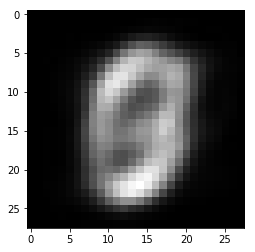

In [24]:
# plot a 9
vec_9 = np.zeros((1, 12))
decoded_9 = decoder.predict(vec_9)
plt.imshow(decoded_9.reshape(28, 28), cmap = plt.cm.gray)

In [14]:
K.clear_session()